# Feature Engineering - Hotel Reservations Dataset



## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
df = pd.read_csv("Hotel Reservations.csv")
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## 2. Feature Engineering

We'll create multiple meaningful features that can improve model performance.

### Feature 1: Total Stay Nights

**Rationale**: Combining weekend and weeknight stays gives us the total duration of the stay, which is a strong indicator of booking commitment and cancellation likelihood.

Total Stay Nights Statistics:
count    36275.000000
mean         3.015024
std          1.786017
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         24.000000
Name: total_stay_nights, dtype: float64


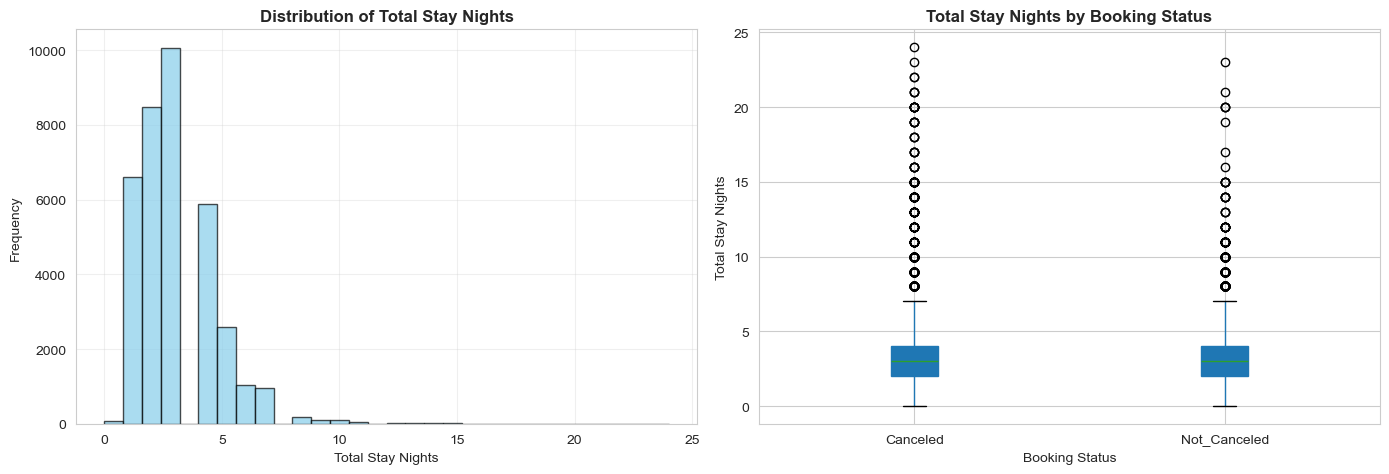


Average Total Stay Nights by Booking Status:
booking_status
Canceled        3.279764
Not_Canceled    2.886019
Name: total_stay_nights, dtype: float64


In [3]:
# Create total stay nights feature
df['total_stay_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

print("Total Stay Nights Statistics:")
print(df['total_stay_nights'].describe())

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df['total_stay_nights'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Distribution of Total Stay Nights', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Stay Nights')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# By booking status
df.boxplot(column='total_stay_nights', by='booking_status', ax=axes[1], patch_artist=True)
axes[1].set_title('Total Stay Nights by Booking Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Booking Status')
axes[1].set_ylabel('Total Stay Nights')

plt.suptitle('')
plt.tight_layout()
plt.show()

# Cancellation rate by stay duration
print("\nAverage Total Stay Nights by Booking Status:")
print(df.groupby('booking_status')['total_stay_nights'].mean())

### Feature 2: Total Guests

**Rationale**: The total number of guests (adults + children) indicates the party size, which affects booking stability and cancellation patterns.

Total Guests Statistics:
count    36275.000000
mean         1.950241
std          0.650327
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: total_guests, dtype: float64


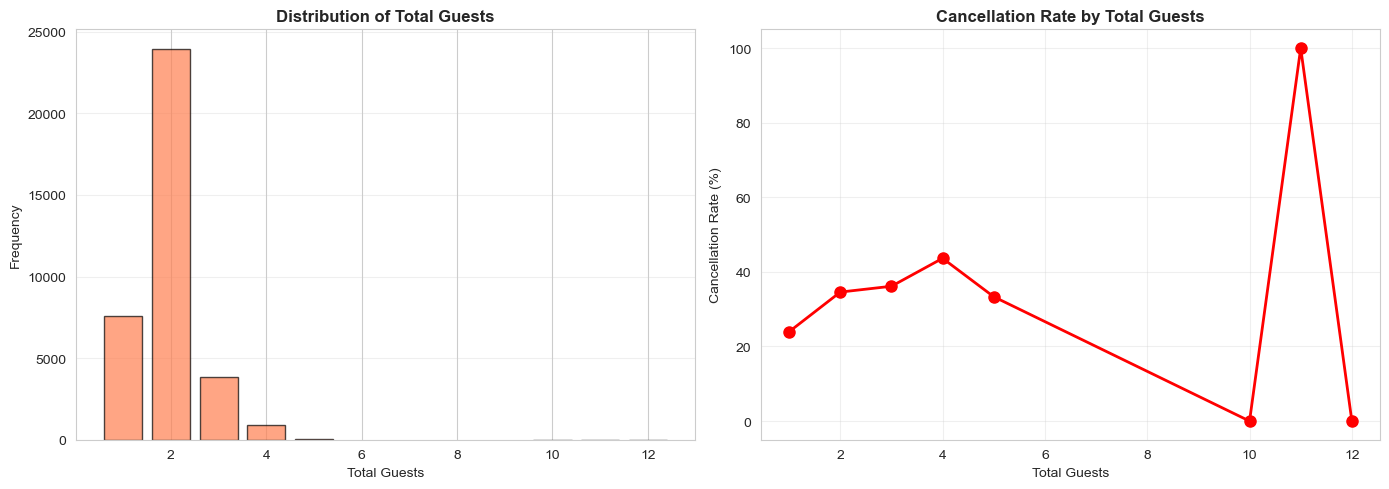


Average Total Guests by Booking Status:
booking_status
Canceled        2.033908
Not_Canceled    1.909471
Name: total_guests, dtype: float64


In [4]:
# Create total guests feature
df['total_guests'] = df['no_of_adults'] + df['no_of_children']

print("Total Guests Statistics:")
print(df['total_guests'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
guest_counts = df['total_guests'].value_counts().sort_index()
axes[0].bar(guest_counts.index, guest_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Distribution of Total Guests', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Guests')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3, axis='y')

# Cancellation rate by total guests
cancellation_by_guests = df.groupby('total_guests')['booking_status'].apply(
    lambda x: (x == 'Canceled').sum() / len(x) * 100
).sort_index()
axes[1].plot(cancellation_by_guests.index, cancellation_by_guests.values, 
            marker='o', linewidth=2, markersize=8, color='red')
axes[1].set_title('Cancellation Rate by Total Guests', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Guests')
axes[1].set_ylabel('Cancellation Rate (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAverage Total Guests by Booking Status:")
print(df.groupby('booking_status')['total_guests'].mean())

### Feature 3: Booking Lead Time Category

**Rationale**: Categorizing lead time into short/medium/long helps capture non-linear relationships. Last-minute bookings and very early bookings may have different cancellation patterns.

Lead time quartiles: [ 29. 100.]

Lead Time Category Distribution:
lead_time_category
Medium    12233
Short     12152
Long      11890
Name: count, dtype: int64


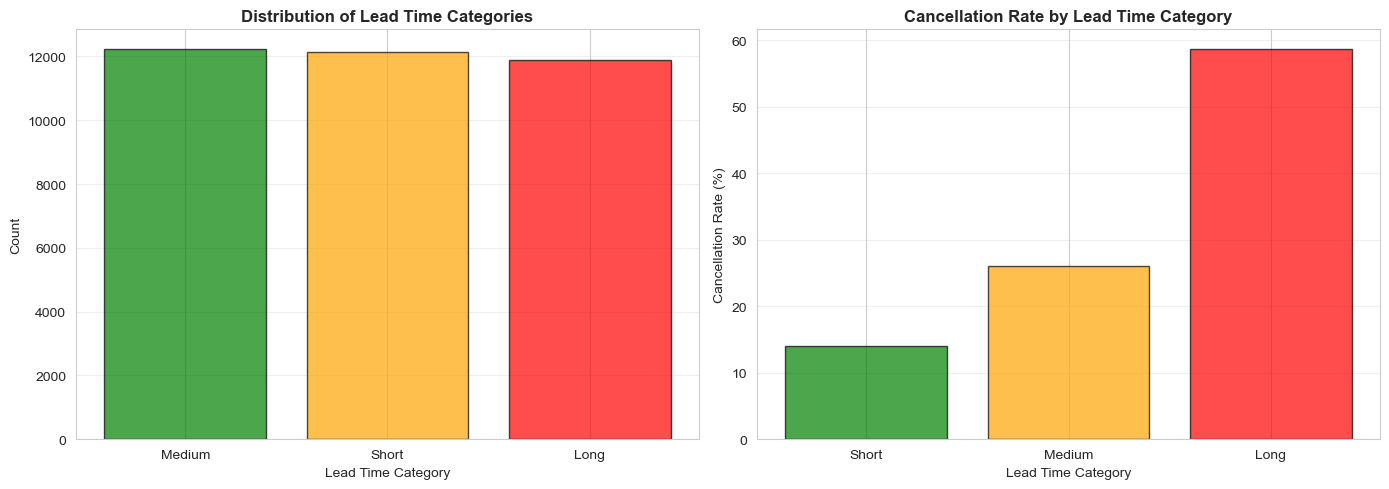


Cancellation Rate by Lead Time Category:
lead_time_category
Long      58.713204
Medium    26.101529
Short     14.079987
Name: booking_status, dtype: float64


In [5]:
# Define lead time categories based on quartiles
lead_time_quartiles = df['lead_time'].quantile([0.33, 0.67])
print(f"Lead time quartiles: {lead_time_quartiles.values}")

def categorize_lead_time(lead_time):
    if lead_time <= lead_time_quartiles.iloc[0]:
        return 'Short'  # 0-33rd percentile
    elif lead_time <= lead_time_quartiles.iloc[1]:
        return 'Medium'  # 33rd-67th percentile
    else:
        return 'Long'  # 67th-100th percentile

df['lead_time_category'] = df['lead_time'].apply(categorize_lead_time)

print("\nLead Time Category Distribution:")
print(df['lead_time_category'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
category_counts = df['lead_time_category'].value_counts()
axes[0].bar(category_counts.index, category_counts.values, 
           edgecolor='black', alpha=0.7, color=['green', 'orange', 'red'])
axes[0].set_title('Distribution of Lead Time Categories', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lead Time Category')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Cancellation rate by category
cancellation_by_category = df.groupby('lead_time_category')['booking_status'].apply(
    lambda x: (x == 'Canceled').sum() / len(x) * 100
)
category_order = ['Short', 'Medium', 'Long']
cancellation_ordered = cancellation_by_category.reindex(category_order)
axes[1].bar(cancellation_ordered.index, cancellation_ordered.values,
           edgecolor='black', alpha=0.7, color=['green', 'orange', 'red'])
axes[1].set_title('Cancellation Rate by Lead Time Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lead Time Category')
axes[1].set_ylabel('Cancellation Rate (%)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCancellation Rate by Lead Time Category:")
print(cancellation_by_category)

### Feature 4: Average Price Per Guest

**Rationale**: Price per guest normalizes the room price by party size, providing a better measure of value perception and affordability, which influences cancellation decisions.

Average Price Per Guest Statistics:
count    36275.000000
mean        57.554657
std         25.517541
min          0.000000
25%         42.000000
50%         51.750000
75%         66.012500
max        279.200000
Name: avg_price_per_guest, dtype: float64


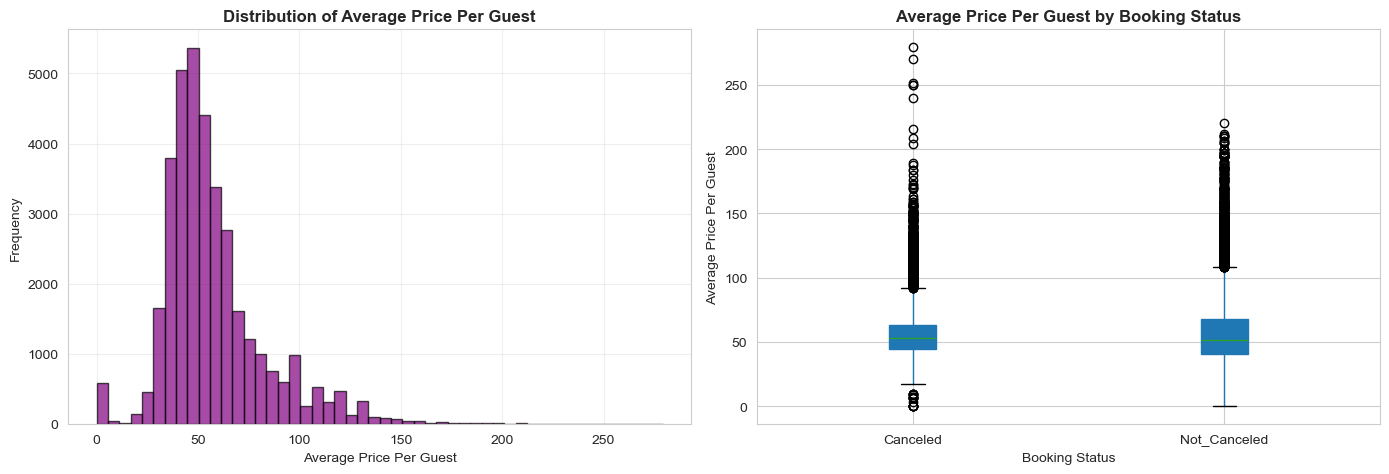


Average Price Per Guest by Booking Status:
booking_status
Canceled        58.768716
Not_Canceled    56.963058
Name: avg_price_per_guest, dtype: float64


In [6]:
# Create average price per guest (handle division by zero)
df['avg_price_per_guest'] = df.apply(
    lambda row: row['avg_price_per_room'] / row['total_guests'] if row['total_guests'] > 0 else row['avg_price_per_room'],
    axis=1
)

print("Average Price Per Guest Statistics:")
print(df['avg_price_per_guest'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df['avg_price_per_guest'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_title('Distribution of Average Price Per Guest', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Average Price Per Guest')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# By booking status
df.boxplot(column='avg_price_per_guest', by='booking_status', ax=axes[1], patch_artist=True)
axes[1].set_title('Average Price Per Guest by Booking Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Booking Status')
axes[1].set_ylabel('Average Price Per Guest')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nAverage Price Per Guest by Booking Status:")
print(df.groupby('booking_status')['avg_price_per_guest'].mean())

### Feature 5: Weekend Booking Flag

**Rationale**: Bookings that include weekend nights may have different characteristics (leisure vs business travel) affecting cancellation likelihood.

Weekend Booking Flag Distribution:
has_weekend_nights
1    19403
0    16872
Name: count, dtype: int64

Percentage:
has_weekend_nights
1    53.488629
0    46.511371
Name: proportion, dtype: float64


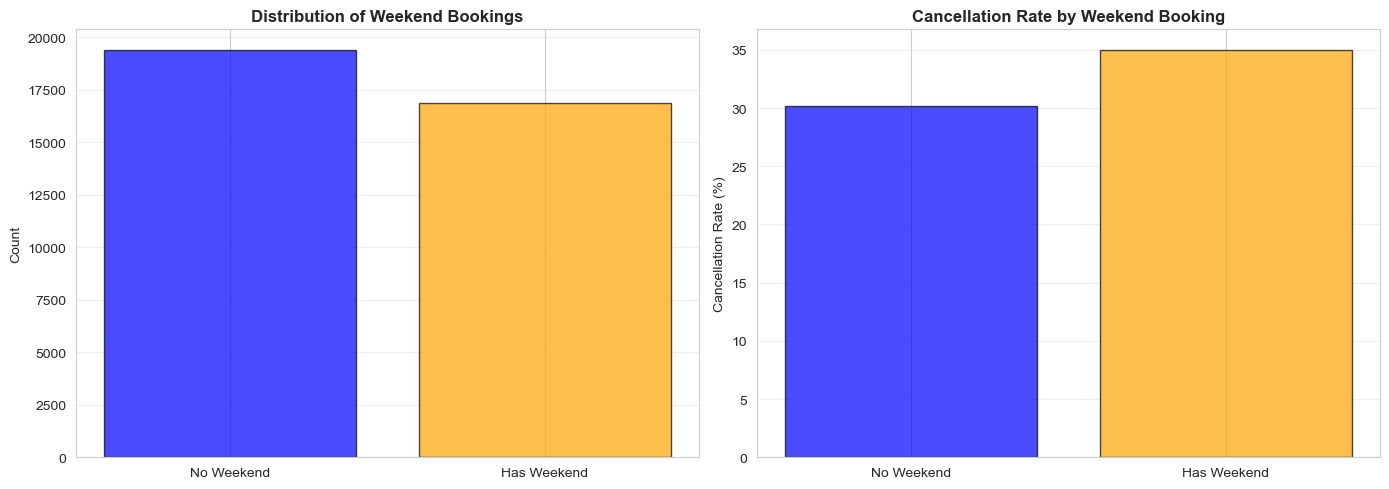


Cancellation Rate by Weekend Booking:
has_weekend_nights
0    30.186107
1    35.004896
Name: booking_status, dtype: float64


In [7]:
# Create weekend booking flag
df['has_weekend_nights'] = (df['no_of_weekend_nights'] > 0).astype(int)

print("Weekend Booking Flag Distribution:")
print(df['has_weekend_nights'].value_counts())
print("\nPercentage:")
print(df['has_weekend_nights'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
weekend_counts = df['has_weekend_nights'].value_counts()
axes[0].bar(['No Weekend', 'Has Weekend'], weekend_counts.values,
           edgecolor='black', alpha=0.7, color=['blue', 'orange'])
axes[0].set_title('Distribution of Weekend Bookings', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Cancellation rate
cancellation_by_weekend = df.groupby('has_weekend_nights')['booking_status'].apply(
    lambda x: (x == 'Canceled').sum() / len(x) * 100
)
axes[1].bar(['No Weekend', 'Has Weekend'], cancellation_by_weekend.values,
           edgecolor='black', alpha=0.7, color=['blue', 'orange'])
axes[1].set_title('Cancellation Rate by Weekend Booking', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cancellation Rate (%)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCancellation Rate by Weekend Booking:")
print(cancellation_by_weekend)

### Feature 6: Booking Value Score

**Rationale**: Combines price and stay duration to create a total booking value metric, indicating the financial commitment level.

Booking Value Statistics:
count    36275.000000
mean       312.812646
std        217.458185
min          0.000000
25%        176.000000
50%        270.000000
75%        392.920000
max       3910.000000
Name: booking_value, dtype: float64


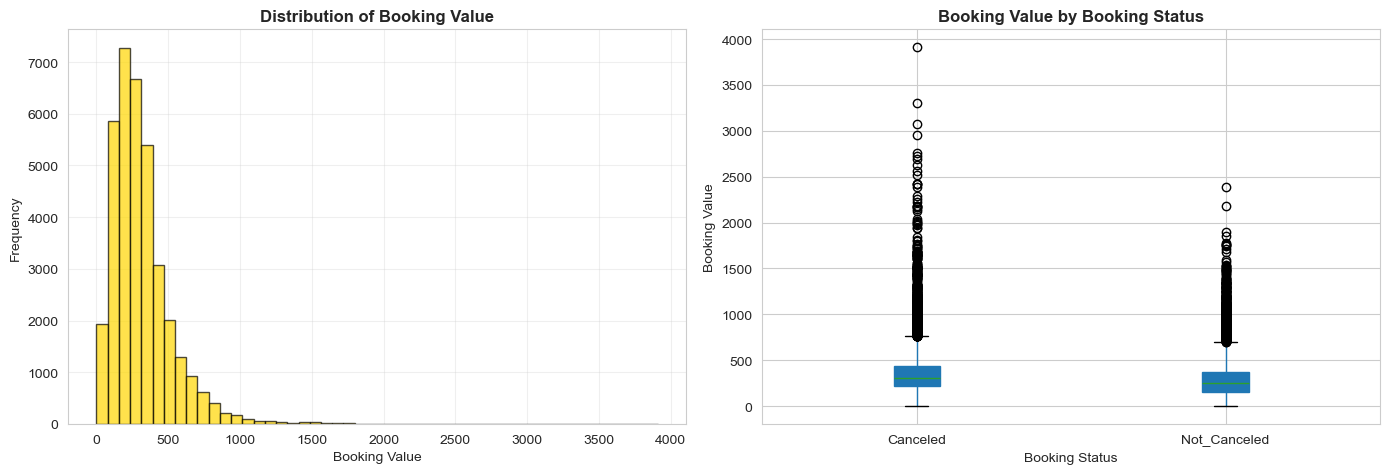


Average Booking Value by Booking Status:
booking_status
Canceled        361.478676
Not_Canceled    289.098182
Name: booking_value, dtype: float64


In [8]:
# Create booking value score (total price for the stay)
df['booking_value'] = df['avg_price_per_room'] * df['total_stay_nights']

print("Booking Value Statistics:")
print(df['booking_value'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution (log scale for better visualization)
axes[0].hist(df['booking_value'], bins=50, edgecolor='black', alpha=0.7, color='gold')
axes[0].set_title('Distribution of Booking Value', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Booking Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# By booking status
df.boxplot(column='booking_value', by='booking_status', ax=axes[1], patch_artist=True)
axes[1].set_title('Booking Value by Booking Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Booking Status')
axes[1].set_ylabel('Booking Value')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nAverage Booking Value by Booking Status:")
print(df.groupby('booking_status')['booking_value'].mean())

### Feature 7: Special Treatment Index

**Rationale**: Combines special requests with parking needs to create an index of special treatment requirements, indicating customer engagement level.

Special Treatment Index Statistics:
count    36275.000000
mean         0.650641
std          0.819848
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: special_treatment_index, dtype: float64

Value Counts:
special_treatment_index
0    19458
1    11166
2     4656
3      866
4      119
5       10
Name: count, dtype: int64


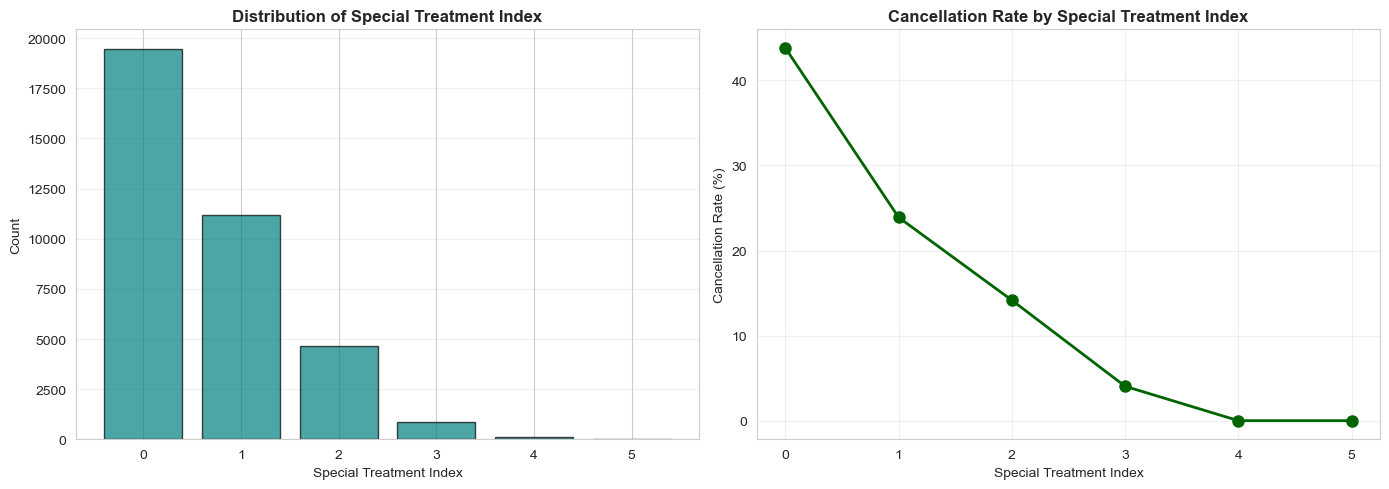

In [9]:
# Create special treatment index
df['special_treatment_index'] = df['no_of_special_requests'] + df['required_car_parking_space']

print("Special Treatment Index Statistics:")
print(df['special_treatment_index'].describe())
print("\nValue Counts:")
print(df['special_treatment_index'].value_counts().sort_index())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
treatment_counts = df['special_treatment_index'].value_counts().sort_index()
axes[0].bar(treatment_counts.index, treatment_counts.values,
           edgecolor='black', alpha=0.7, color='teal')
axes[0].set_title('Distribution of Special Treatment Index', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Special Treatment Index')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Cancellation rate
cancellation_by_treatment = df.groupby('special_treatment_index')['booking_status'].apply(
    lambda x: (x == 'Canceled').sum() / len(x) * 100
).sort_index()
axes[1].plot(cancellation_by_treatment.index, cancellation_by_treatment.values,
            marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_title('Cancellation Rate by Special Treatment Index', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Special Treatment Index')
axes[1].set_ylabel('Cancellation Rate (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Feature 8: Customer Loyalty Score

**Rationale**: Combines repeated guest status with previous booking history to create a loyalty metric, which strongly influences cancellation behavior.

Customer Loyalty Score Statistics:
count    36275.000000
mean         0.493150
std          4.124566
min        -27.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        109.000000
Name: customer_loyalty_score, dtype: float64


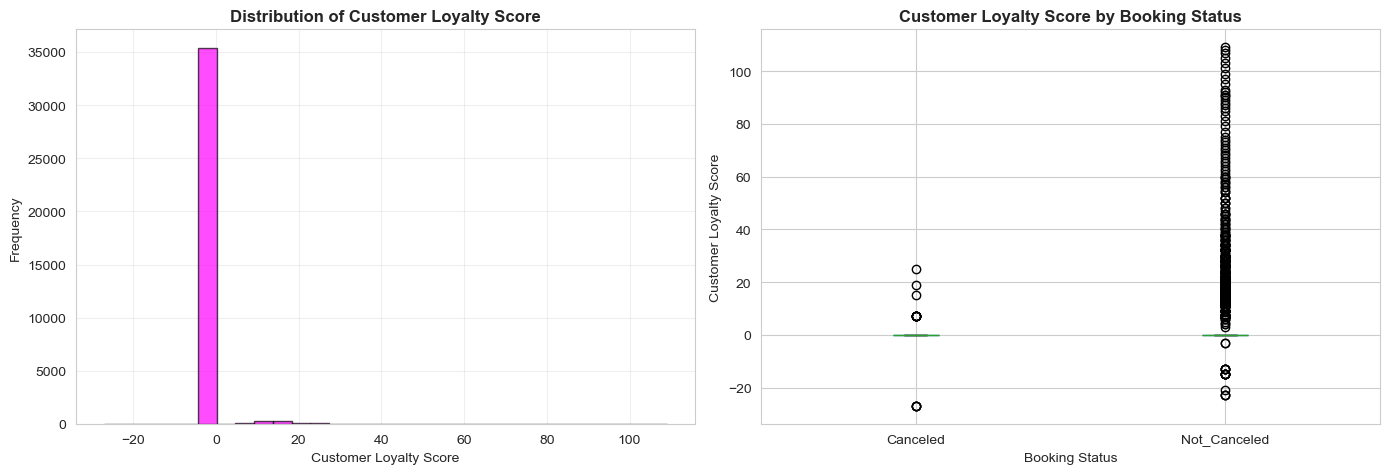


Average Customer Loyalty Score by Booking Status:
booking_status
Canceled        0.001178
Not_Canceled    0.732882
Name: customer_loyalty_score, dtype: float64


In [10]:
# Create customer loyalty score
# Formula: (repeated_guest * 10) + (previous_bookings_not_canceled * 2) - (previous_cancellations * 3)
df['customer_loyalty_score'] = (
    (df['repeated_guest'] * 10) + 
    (df['no_of_previous_bookings_not_canceled'] * 2) - 
    (df['no_of_previous_cancellations'] * 3)
)

print("Customer Loyalty Score Statistics:")
print(df['customer_loyalty_score'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df['customer_loyalty_score'], bins=30, edgecolor='black', alpha=0.7, color='magenta')
axes[0].set_title('Distribution of Customer Loyalty Score', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Customer Loyalty Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# By booking status
df.boxplot(column='customer_loyalty_score', by='booking_status', ax=axes[1], patch_artist=True)
axes[1].set_title('Customer Loyalty Score by Booking Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Booking Status')
axes[1].set_ylabel('Customer Loyalty Score')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nAverage Customer Loyalty Score by Booking Status:")
print(df.groupby('booking_status')['customer_loyalty_score'].mean())

### Feature 9: Arrival Season

**Rationale**: Grouping months into seasons captures seasonal travel patterns and their impact on cancellations.

Arrival Season Distribution:
arrival_season
Fall      12908
Summer     9936
Spring     7692
Winter     5739
Name: count, dtype: int64


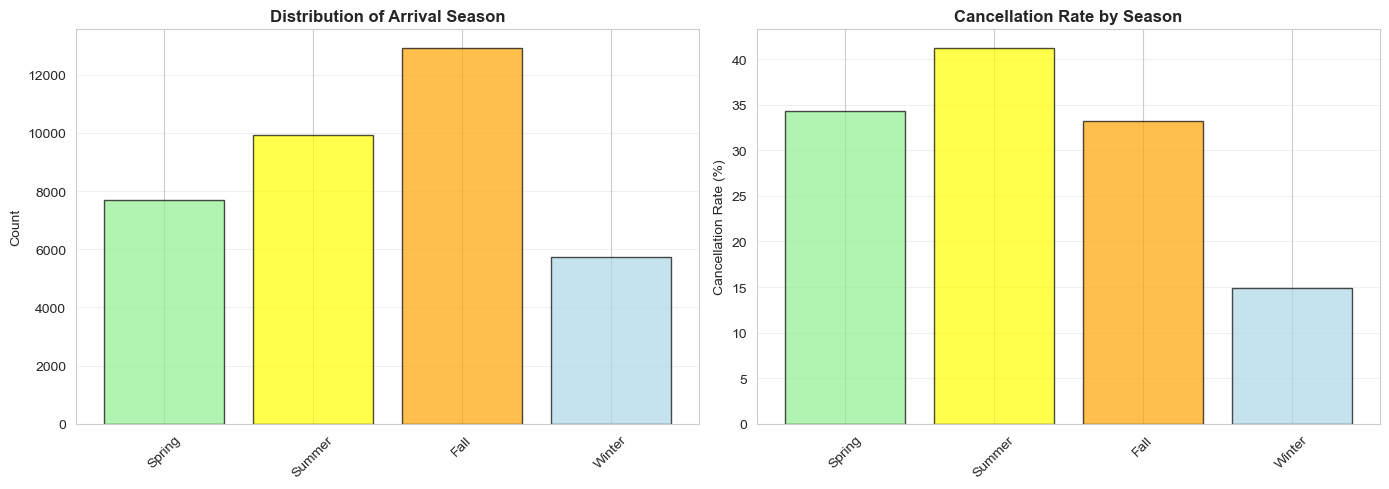


Cancellation Rate by Season:
arrival_season
Fall      33.258444
Spring    34.360374
Summer    41.193639
Winter    14.915491
Name: booking_status, dtype: float64


In [11]:
# Create arrival season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

df['arrival_season'] = df['arrival_month'].apply(get_season)

print("Arrival Season Distribution:")
print(df['arrival_season'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
season_counts = df['arrival_season'].value_counts()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_counts_ordered = season_counts.reindex(season_order)
axes[0].bar(season_counts_ordered.index, season_counts_ordered.values,
           edgecolor='black', alpha=0.7, color=['lightgreen', 'yellow', 'orange', 'lightblue'])
axes[0].set_title('Distribution of Arrival Season', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Cancellation rate by season
cancellation_by_season = df.groupby('arrival_season')['booking_status'].apply(
    lambda x: (x == 'Canceled').sum() / len(x) * 100
)
cancellation_ordered = cancellation_by_season.reindex(season_order)
axes[1].bar(cancellation_ordered.index, cancellation_ordered.values,
           edgecolor='black', alpha=0.7, color=['lightgreen', 'yellow', 'orange', 'lightblue'])
axes[1].set_title('Cancellation Rate by Season', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cancellation Rate (%)')
axes[1].grid(True, alpha=0.3, axis='y')
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nCancellation Rate by Season:")
print(cancellation_by_season)

### Feature 10: Booking Complexity Score

**Rationale**: Complex bookings (more guests, longer stays, special requests) may indicate higher commitment and lower cancellation risk.

Booking Complexity Score Statistics:
count    36275.000000
mean         0.113345
std          0.064246
min          0.000000
25%          0.060606
50%          0.103939
75%          0.153939
max          0.521818
Name: booking_complexity_score, dtype: float64


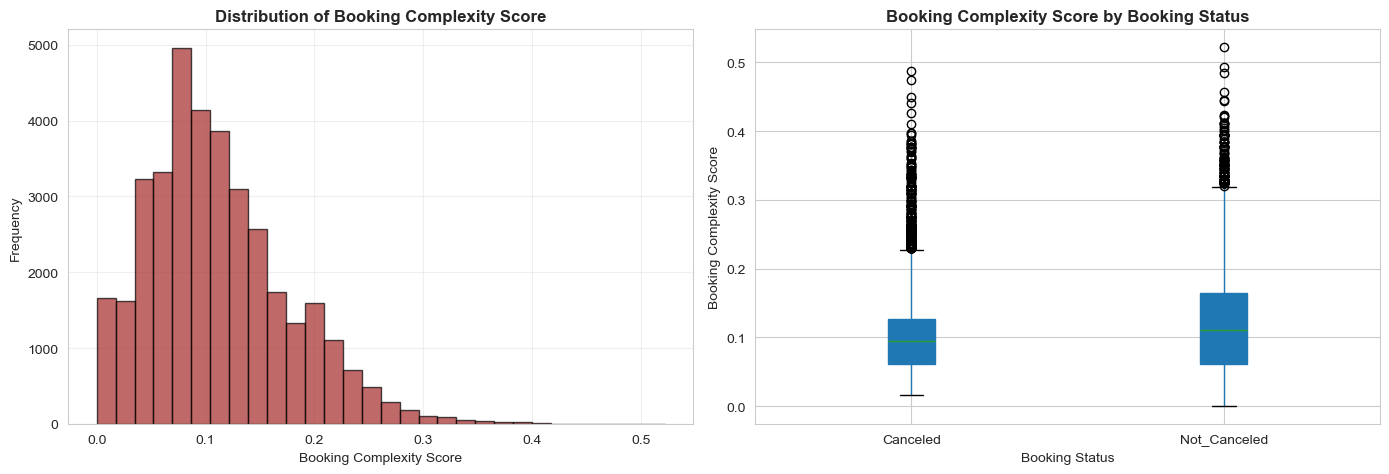


Average Booking Complexity Score by Booking Status:
booking_status
Canceled        0.102938
Not_Canceled    0.118417
Name: booking_complexity_score, dtype: float64


In [12]:
# Normalize components to 0-1 scale for fair weighting
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
components = df[['total_guests', 'total_stay_nights', 'no_of_special_requests']].copy()
components_scaled = scaler.fit_transform(components)

# Create complexity score (weighted sum)
df['booking_complexity_score'] = (
    components_scaled[:, 0] * 0.3 +  # total_guests weight
    components_scaled[:, 1] * 0.4 +  # total_stay_nights weight
    components_scaled[:, 2] * 0.3    # special_requests weight
)

print("Booking Complexity Score Statistics:")
print(df['booking_complexity_score'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df['booking_complexity_score'], bins=30, edgecolor='black', alpha=0.7, color='brown')
axes[0].set_title('Distribution of Booking Complexity Score', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Booking Complexity Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# By booking status
df.boxplot(column='booking_complexity_score', by='booking_status', ax=axes[1], patch_artist=True)
axes[1].set_title('Booking Complexity Score by Booking Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Booking Status')
axes[1].set_ylabel('Booking Complexity Score')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nAverage Booking Complexity Score by Booking Status:")
print(df.groupby('booking_status')['booking_complexity_score'].mean())

## 3. Feature Summary and Correlation Analysis

In [13]:
# List all new features
new_features = [
    'total_stay_nights',
    'total_guests',
    'lead_time_category',
    'avg_price_per_guest',
    'has_weekend_nights',
    'booking_value',
    'special_treatment_index',
    'customer_loyalty_score',
    'arrival_season',
    'booking_complexity_score'
]

print("="*80)
print("ENGINEERED FEATURES SUMMARY")
print("="*80)
print(f"\nTotal new features created: {len(new_features)}")
print("\nFeature List:")
for i, feature in enumerate(new_features, 1):
    print(f"{i}. {feature}")

ENGINEERED FEATURES SUMMARY

Total new features created: 10

Feature List:
1. total_stay_nights
2. total_guests
3. lead_time_category
4. avg_price_per_guest
5. has_weekend_nights
6. booking_value
7. special_treatment_index
8. customer_loyalty_score
9. arrival_season
10. booking_complexity_score


In [14]:
# Correlation of new numerical features with target
# Convert booking_status to binary
df['booking_status_binary'] = (df['booking_status'] == 'Canceled').astype(int)

numerical_new_features = [
    'total_stay_nights',
    'total_guests',
    'avg_price_per_guest',
    'has_weekend_nights',
    'booking_value',
    'special_treatment_index',
    'customer_loyalty_score',
    'booking_complexity_score'
]

correlations = df[numerical_new_features + ['booking_status_binary']].corr()['booking_status_binary'].drop('booking_status_binary')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("\n" + "="*80)
print("CORRELATION WITH BOOKING CANCELLATION")
print("="*80)
print("\nAbsolute Correlation (sorted):")
for feature, corr in correlations_sorted.items():
    actual_corr = correlations[feature]
    print(f"{feature:35s}: {actual_corr:+.4f} (|{corr:.4f}|)")


CORRELATION WITH BOOKING CANCELLATION

Absolute Correlation (sorted):
special_treatment_index            : -0.2609 (|0.2609|)
booking_value                      : +0.1562 (|0.1562|)
booking_complexity_score           : -0.1131 (|0.1131|)
total_stay_nights                  : +0.1035 (|0.1035|)
total_guests                       : +0.0898 (|0.0898|)
customer_loyalty_score             : -0.0833 (|0.0833|)
has_weekend_nights                 : +0.0512 (|0.0512|)
avg_price_per_guest                : +0.0332 (|0.0332|)


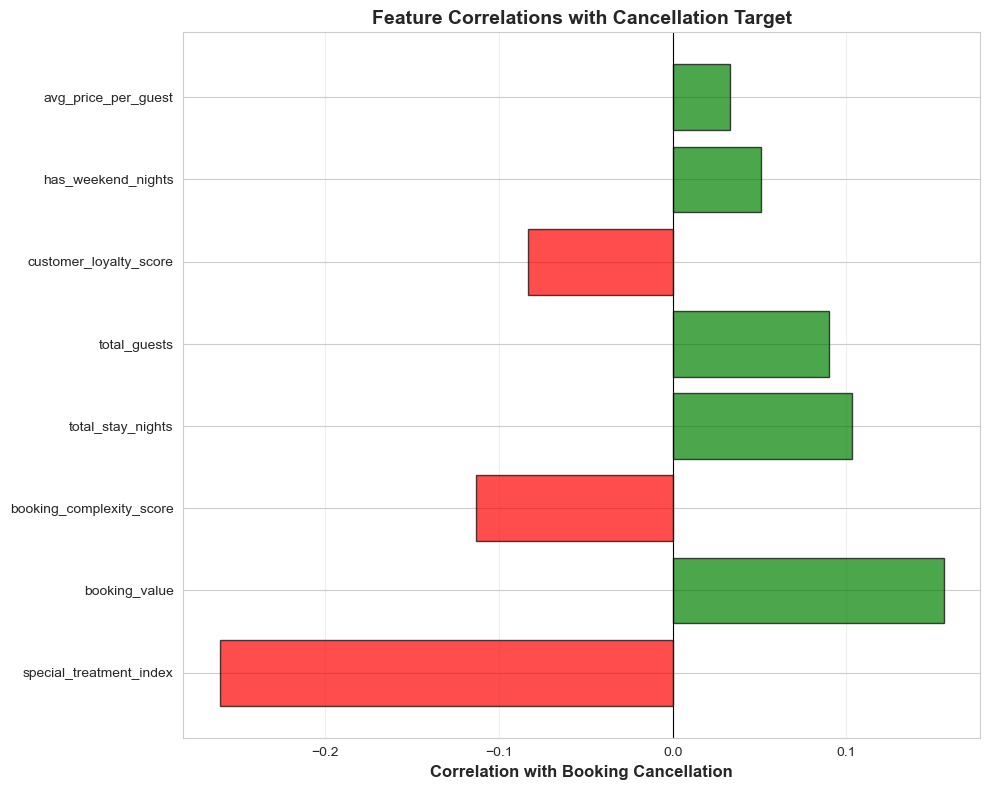

In [15]:
# Visualize correlations
plt.figure(figsize=(10, 8))
correlations_sorted_with_sign = correlations.reindex(correlations_sorted.index)
colors = ['red' if x < 0 else 'green' for x in correlations_sorted_with_sign.values]
plt.barh(range(len(correlations_sorted_with_sign)), correlations_sorted_with_sign.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(correlations_sorted_with_sign)), correlations_sorted_with_sign.index)
plt.xlabel('Correlation with Booking Cancellation', fontsize=12, fontweight='bold')
plt.title('Feature Correlations with Cancellation Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 4. Feature Importance Justification

### How These Features Improve Model Performance:

#### 1. **Total Stay Nights**
- **Benefit**: Captures overall booking duration in a single feature
- **Impact**: Longer stays indicate higher commitment, reducing cancellation likelihood
- **Model Improvement**: Reduces dimensionality while preserving information from two features

#### 2. **Total Guests**
- **Benefit**: Aggregates party size information
- **Impact**: Larger groups are less likely to cancel due to coordination complexity
- **Model Improvement**: Provides a single metric for group size analysis

#### 3. **Lead Time Category**
- **Benefit**: Captures non-linear relationships in booking advance time
- **Impact**: Different booking windows have distinct cancellation patterns
- **Model Improvement**: Helps tree-based models create better splits; easier for linear models to process

#### 4. **Average Price Per Guest**
- **Benefit**: Normalizes price by party size for fair comparison
- **Impact**: Better represents perceived value and affordability
- **Model Improvement**: Removes confounding effect of party size on price sensitivity

#### 5. **Weekend Booking Flag**
- **Benefit**: Binary indicator for leisure vs business travel patterns
- **Impact**: Weekend bookings often indicate leisure travel with different cancellation behavior
- **Model Improvement**: Simplifies weekend information into actionable binary feature

#### 6. **Booking Value**
- **Benefit**: Represents total financial commitment
- **Impact**: Higher value bookings indicate greater investment and planning
- **Model Improvement**: Combines price and duration into single economic indicator

#### 7. **Special Treatment Index**
- **Benefit**: Measures customer engagement level
- **Impact**: Customers making special requests show higher commitment
- **Model Improvement**: Aggregates multiple engagement signals

#### 8. **Customer Loyalty Score**
- **Benefit**: Comprehensive loyalty metric
- **Impact**: Loyal customers have predictable behavior patterns
- **Model Improvement**: Combines multiple historical features with appropriate weights

#### 9. **Arrival Season**
- **Benefit**: Captures seasonal travel patterns
- **Impact**: Different seasons have distinct demand and cancellation characteristics
- **Model Improvement**: Groups months into meaningful categories for better generalization

#### 10. **Booking Complexity Score**
- **Benefit**: Holistic measure of booking sophistication
- **Impact**: Complex bookings indicate serious travel plans
- **Model Improvement**: Weighted combination of multiple complexity indicators

### Overall Model Performance Benefits:

1. **Reduced Dimensionality**: Combining related features reduces curse of dimensionality
2. **Better Interpretability**: Engineered features are more meaningful to stakeholders
3. **Improved Generalization**: Categorical features help models generalize better
4. **Non-linear Relationships**: Captures complex interactions between original features
5. **Domain Knowledge Integration**: Incorporates business logic into feature design
6. **Reduced Multicollinearity**: Thoughtful feature engineering can reduce redundancy
7. **Enhanced Predictive Power**: New features expose hidden patterns in the data

## 5. Save Enhanced Dataset

In [16]:
# Display final dataset info
print("="*80)
print("FINAL DATASET INFORMATION")
print("="*80)
print(f"\nOriginal features: {df.shape[1] - len(new_features) - 1}")  # -1 for booking_status_binary
print(f"New features: {len(new_features)}")
print(f"Total features: {df.shape[1]}")
print(f"Total records: {df.shape[0]:,}")

# Save the enhanced dataset
output_file = 'Hotel_Reservations_Engineered.csv'
df.to_csv(output_file, index=False)
print(f"\nEnhanced dataset saved to: {output_file}")

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE!")
print("="*80)

FINAL DATASET INFORMATION

Original features: 19
New features: 10
Total features: 30
Total records: 36,275

Enhanced dataset saved to: Hotel_Reservations_Engineered.csv

FEATURE ENGINEERING COMPLETE!


In [17]:
# Display sample of enhanced dataset
print("\nSample of Enhanced Dataset:")
display_cols = ['Booking_ID', 'total_stay_nights', 'total_guests', 'lead_time_category', 
                'avg_price_per_guest', 'has_weekend_nights', 'booking_value', 
                'customer_loyalty_score', 'booking_status']
df[display_cols].head(10)


Sample of Enhanced Dataset:


,Booking_ID,total_stay_nights,total_guests,lead_time_category,avg_price_per_guest,has_weekend_nights,booking_value,customer_loyalty_score,booking_status
0,INN00001,3,2,Long,32.500,1,195.00,0,Not_Canceled
1,INN00002,5,2,Short,53.340,1,533.40,0,Not_Canceled
2,INN00003,3,1,Short,60.000,1,180.00,0,Canceled
3,INN00004,2,2,Long,50.000,0,200.00,0,Canceled
4,INN00005,2,2,Medium,47.250,1,189.00,0,Canceled
5,INN00006,2,2,Long,57.500,0,230.00,0,Canceled
6,INN00007,4,2,Medium,53.775,1,430.20,0,Not_Canceled
7,INN00008,4,2,Medium,52.805,1,422.44,0,Not_Canceled
8,INN00009,4,3,Long,32.300,0,387.60,0,Not_Canceled
9,INN00010,5,2,Medium,66.720,0,667.20,0,Not_Canceled
